In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
from astra.torch.models import ResNetClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
%matplotlib inline
# Retina display
%config InlineBackend.figure_format = 'retina'
# Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import torchsummary
from tqdm import tqdm
from astra.torch.data import load_cifar_10
from astra.torch.utils import train_fn


/home/rishabh.mondal/miniconda3/envs/torch_env/lib/python3.11/site-packages/astra/torch/data.py:12: UserWarning: TORCH_HOME not set, setting it to /home/rishabh.mondal/.cache/torch
  warnings.warn(f"TORCH_HOME not set, setting it to {os.environ['TORCH_HOME']}")


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
dataset = load_cifar_10()
dataset

Files already downloaded and verified
Files already downloaded and verified



CIFAR-10 Dataset
length of dataset: 60000
shape of images: torch.Size([3, 32, 32])
len of classes: 10
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
dtype of images: torch.float32
dtype of labels: torch.int64
            

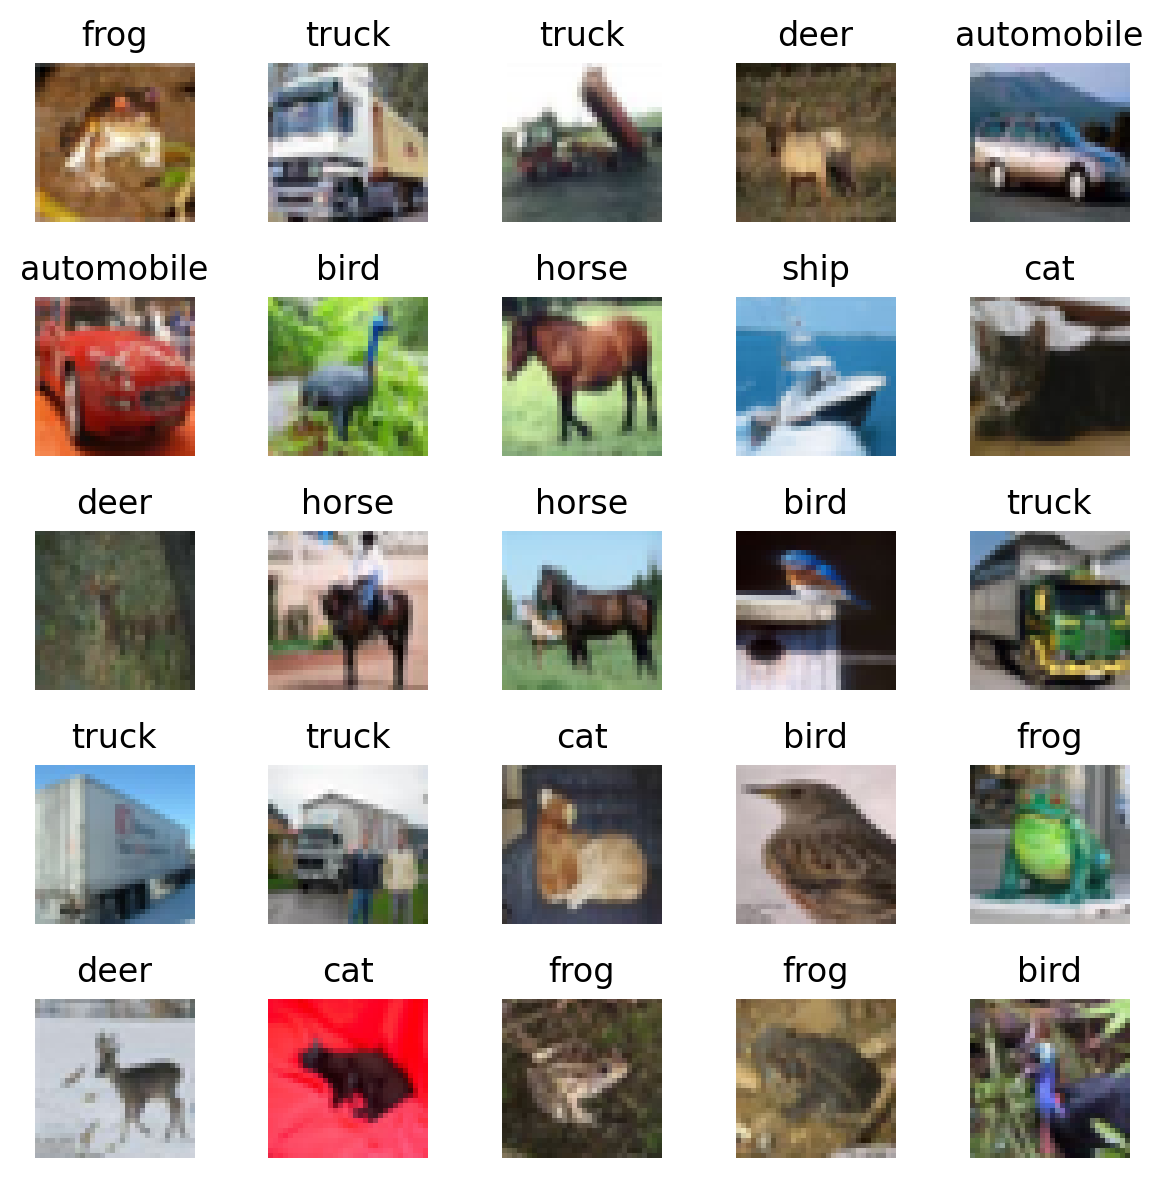

In [5]:
# Plot some images
plt.figure(figsize=(6, 6))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(torch.einsum("chw->hwc", dataset.data[i].cpu()))
    plt.axis("off")
    plt.title(dataset.classes[dataset.targets[i]])
plt.tight_layout()

In [6]:
n_train = 1000
n_test = 20000
y = dataset.targets
X = dataset.data
# y = (y==1).int()
# mask=(y==1)
# X=X[mask]
print(y)

print(X.shape)
print(X.shape, X.dtype)
print(X.min(), X.max())
print(y.shape, y.dtype)

tensor([6, 9, 9,  ..., 5, 1, 7])
torch.Size([60000, 3, 32, 32])
torch.Size([60000, 3, 32, 32]) torch.float32
tensor(0.) tensor(1.)
torch.Size([60000]) torch.int64


In [7]:
classes = dataset.classes
class_1_idx = classes.index("frog")
print(class_1_idx)

6


In [8]:
class_1_mask = y == class_1_idx
print(class_1_mask)
class_1_mask = class_1_mask.int()
print(class_1_mask)
class_1_mask.shape
y = class_1_mask
# X_class_1 = X[class_1_mask]
# y_class_1 = y[class_1_mask]
# # print(y_class_1)

# X_class_0 = X[~class_1_mask]
# y_class_0 = y[~class_1_mask]
# print(y_class_0)
# print(X_class_0.shape)
# print(X_class_1.shape)
# print(y_class_0.shape)
# print(y_class_1)

# #make a new dataset with only class 1 and class 0
# X=torch.cat((X_class_0,X_class_1),0)
# y=torch.cat((y_class_0,y_class_1),0)
# print(X.shape)
# print(y.shape)

tensor([ True, False, False,  ..., False, False, False])
tensor([1, 0, 0,  ..., 0, 0, 0], dtype=torch.int32)


In [9]:
print(y)

tensor([1, 0, 0,  ..., 0, 0, 0], dtype=torch.int32)


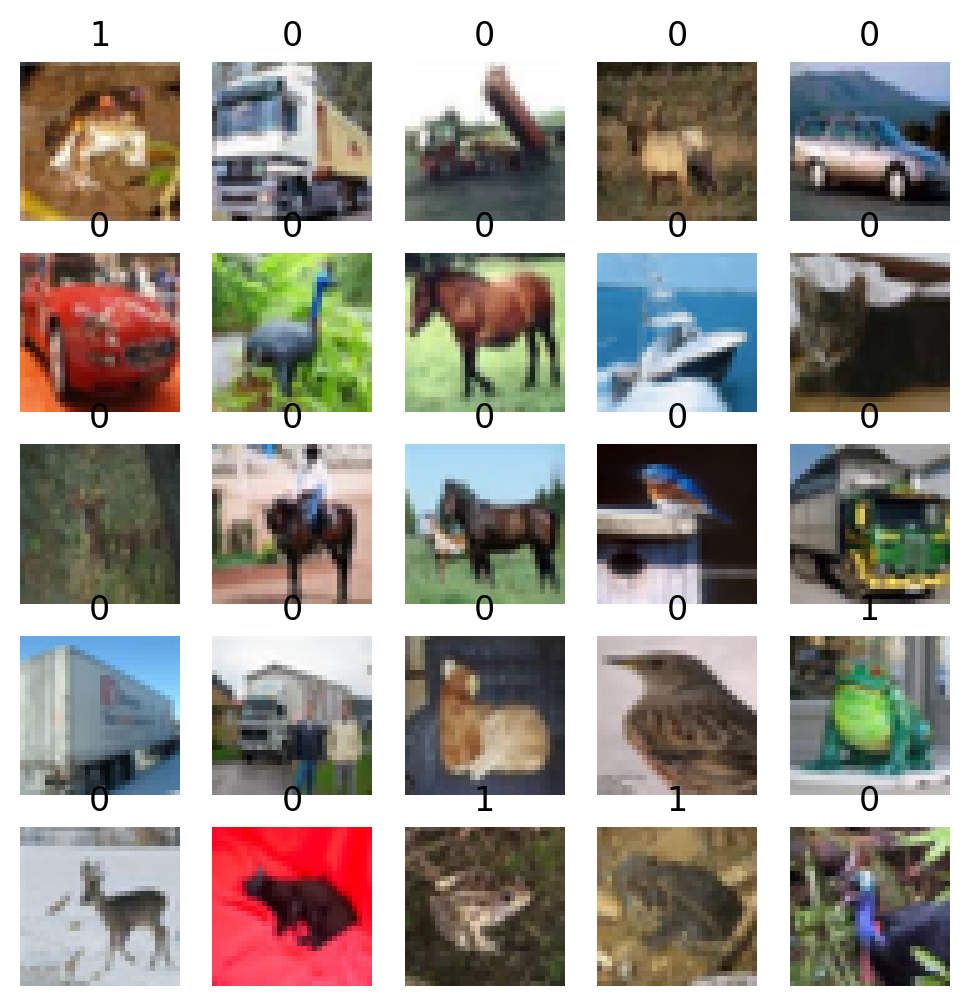

In [10]:
# plot some  images with the new labels in boolean print only label o or 1 not tensor (1,dtype=int64)
plt.figure(figsize=(6, 6))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(torch.einsum("chw->hwc", X[i].cpu()))
    plt.axis("off")
    plt.title(y[i].item())

In [11]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.manual_seed(0)
idx = torch.randperm(len(X))
train_idx = idx[:n_train]
pool_idx = idx[n_train:-n_test]
test_idx = idx[-n_test:]
print(len(train_idx), len(pool_idx), len(test_idx))

1000 39000 20000


In [12]:
resnet = ResNetClassifier(
    models.resnet18, models.ResNet18_Weights.DEFAULT, n_classes=2
).to(device)
resnet

ResNetClassifier(
  (featurizer): ResNet(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1):

In [13]:
torchsummary.summary(resnet, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

train set accuracy: 13.60%
1000 1000
              precision    recall  f1-score   support

           0       0.94      0.03      0.07       893
           1       0.11      0.98      0.20       107

    accuracy                           0.14      1000
   macro avg       0.52      0.51      0.13      1000
weighted avg       0.85      0.14      0.08      1000



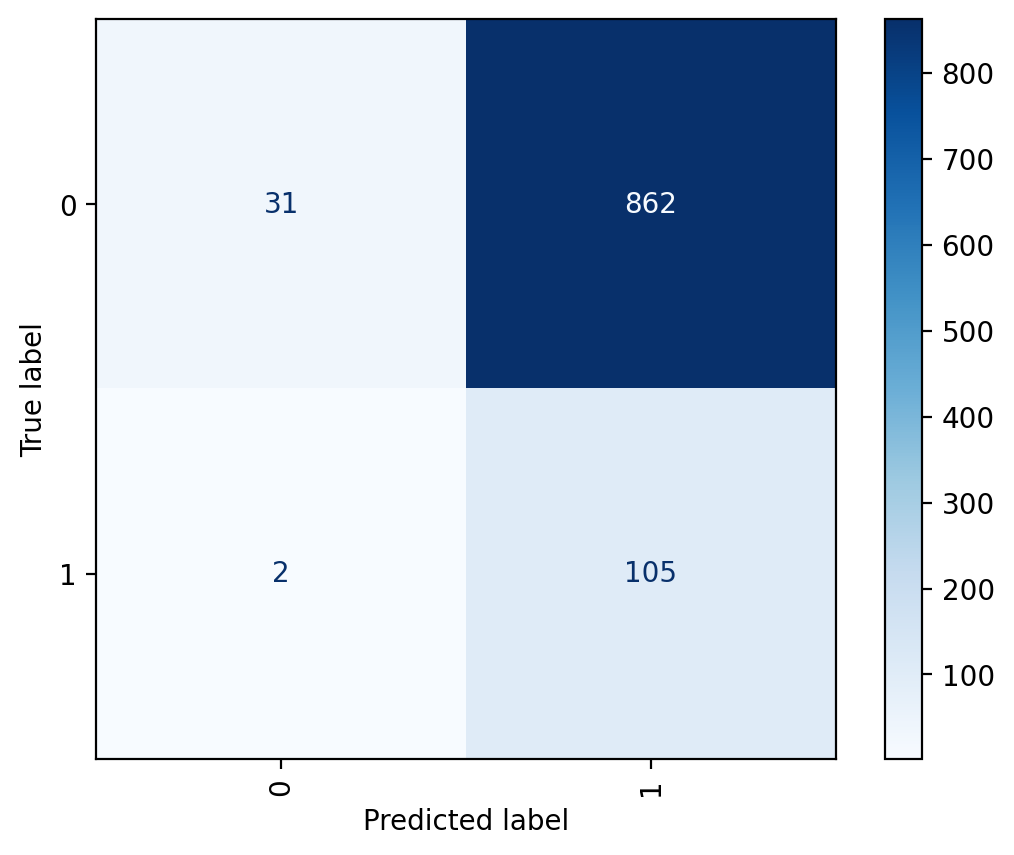

pool set accuracy: 13.01%
39000 39000
              precision    recall  f1-score   support

           0       0.90      0.04      0.07     35115
           1       0.10      0.96      0.18      3885

    accuracy                           0.13     39000
   macro avg       0.50      0.50      0.13     39000
weighted avg       0.82      0.13      0.08     39000



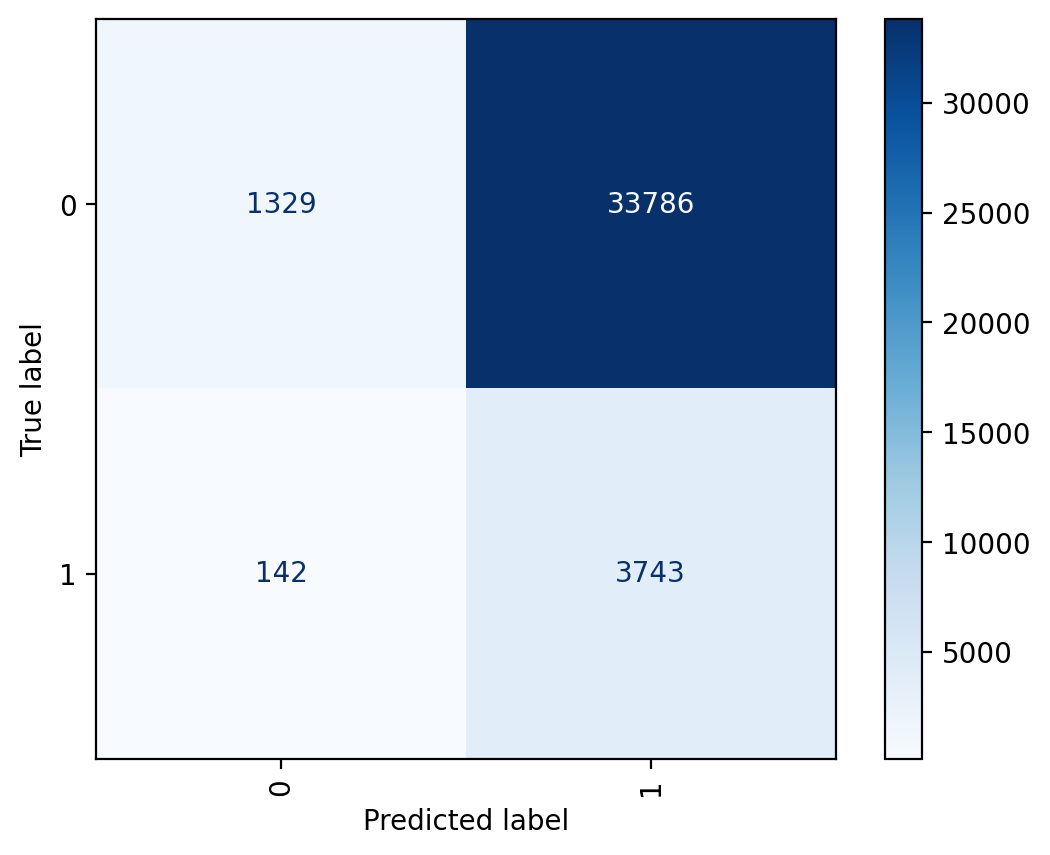

test set accuracy: 13.01%
20000 20000
              precision    recall  f1-score   support

           0       0.90      0.04      0.07     17992
           1       0.10      0.96      0.18      2008

    accuracy                           0.13     20000
   macro avg       0.50      0.50      0.13     20000
weighted avg       0.82      0.13      0.08     20000



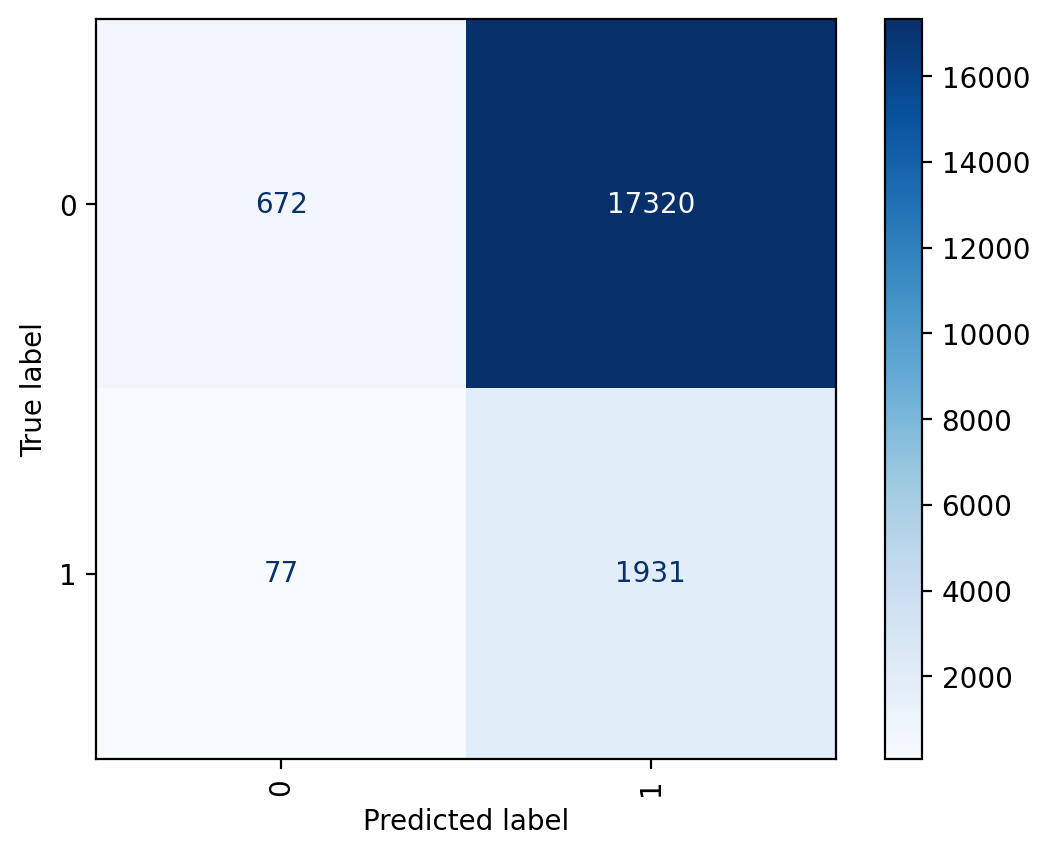

In [14]:
def get_accuracy(net, X, y):
    with torch.no_grad():
        logits_pred = net(X)
        y_pred = logits_pred.argmax(dim=1)
        acc = (y_pred == y).float().mean()
        return y_pred, acc


def predict(net, classes, plot_confusion_matrix=False):
    for i, (name, idx) in enumerate(
        zip(("train", "pool", "test"), [train_idx, pool_idx, test_idx])
    ):
        X_dataset = X[idx].to(device)
        y_dataset = y[idx].to(device)
        y_pred, acc = get_accuracy(net, X_dataset, y_dataset)
        print(f"{name} set accuracy: {acc*100:.2f}%")
        # print the len of true and predicted labels
        print(len(y_dataset), len(y_pred))
        # print classification report
        from sklearn.metrics import classification_report

        print(classification_report(y_dataset.cpu(), y_pred.cpu()))

        if plot_confusion_matrix:
            cm = confusion_matrix(y_dataset.cpu(), y_pred.cpu())
            cm_display = ConfusionMatrixDisplay(cm, display_labels=classes).plot(
                values_format="d", cmap="Blues"
            )
            # Rotate the labels on x-axis to make them readable
            _ = plt.xticks(rotation=90)
            plt.show()


predict(resnet, ["0", "1"], plot_confusion_matrix=True)

2023-11-10 14:20:23.359969: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-10 14:20:25.071913: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-10 14:20:32.255242: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


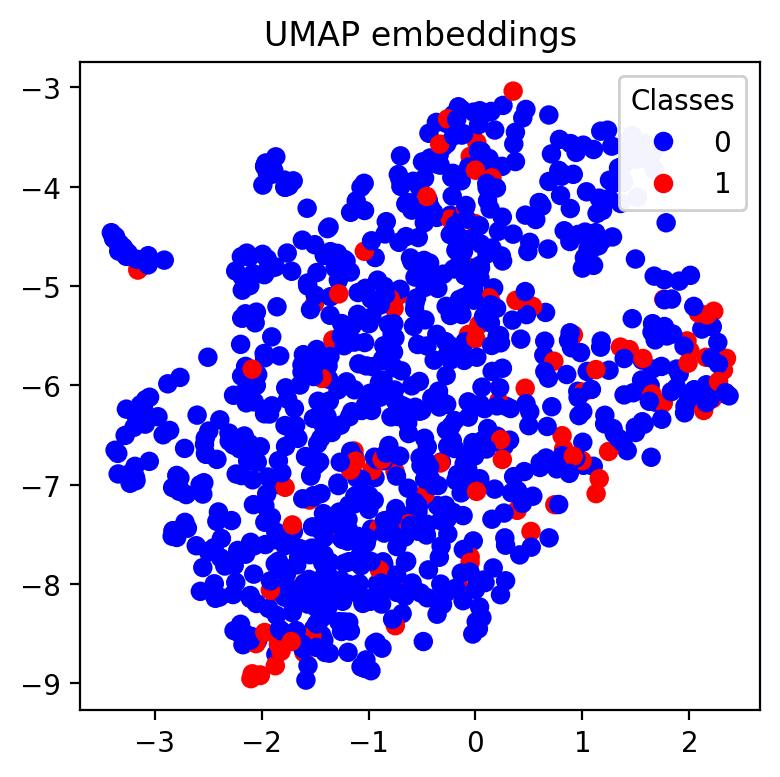

In [15]:
import umap


def viz_embeddings(net, X, y, device):
    reducer = umap.UMAP()
    with torch.no_grad():
        emb = net.featurizer(X.to(device))
    emb = emb.cpu().numpy()
    emb = reducer.fit_transform(emb)
    plt.figure(figsize=(4, 4))
    scatter = plt.scatter(emb[:, 0], emb[:, 1], c=y.cpu().numpy(), cmap="bwr")

    # Create a legend
    legend1 = plt.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
    plt.gca().add_artist(legend1)

    plt.title("UMAP embeddings")
    plt.tight_layout()
    plt.show()


viz_embeddings(resnet, X[train_idx], y[train_idx], device)

In [16]:
print(y[train_idx].shape)
print(X[train_idx].shape)

torch.Size([1000])
torch.Size([1000, 3, 32, 32])


In [17]:
resnet = ResNetClassifier(
    models.resnet18, None, n_classes=2, activation=nn.GELU(), dropout=0.1
).to(device)

# Convert X to float and y to long
X_float = X[train_idx].float()
y_long = y[train_idx].long()

iter_losses, epoch_losses = train_fn(
    resnet,
    X_float,
    y_long,
    nn.CrossEntropyLoss(),
    lr=3e-4,
    batch_size=128,
    epochs=30,
    verbose=False,
)

Text(0, 0.5, 'Training loss')

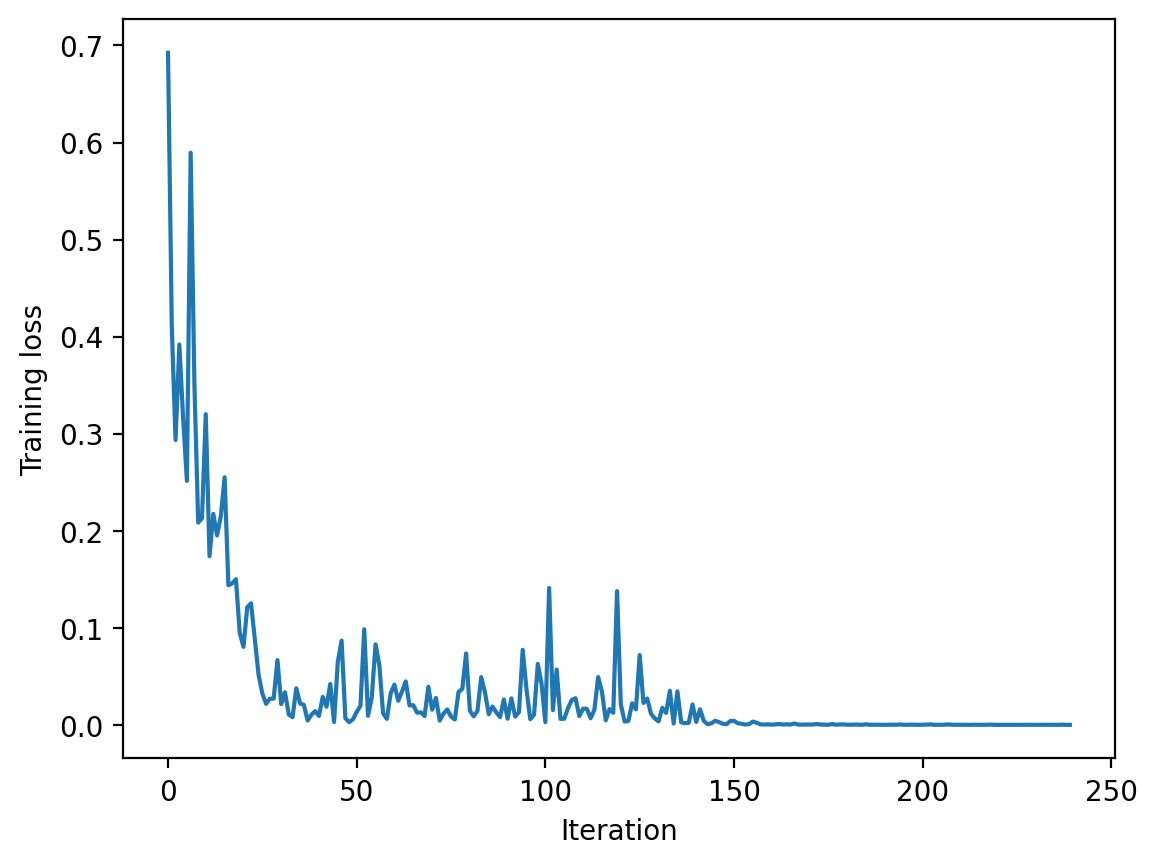

In [18]:
plt.plot(iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Training loss")

train set accuracy: 100.00%
1000 1000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       893
           1       1.00      1.00      1.00       107

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



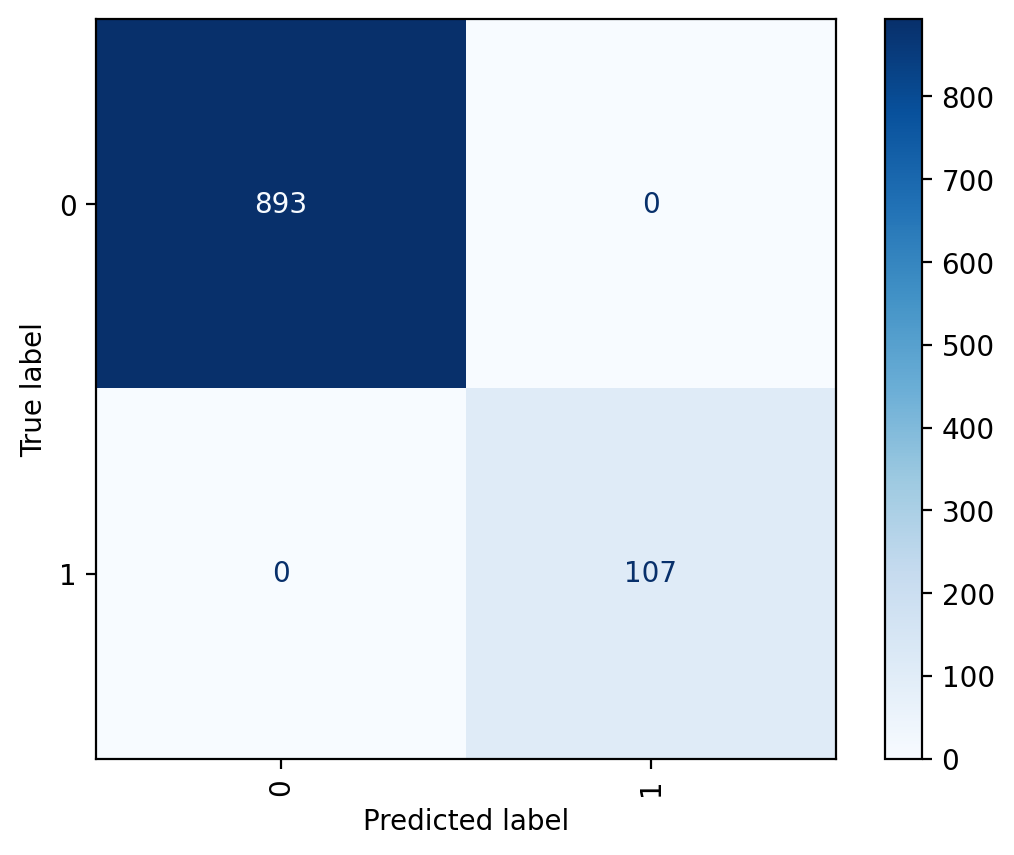

pool set accuracy: 89.84%
39000 39000
              precision    recall  f1-score   support

           0       0.94      0.95      0.94     35115
           1       0.49      0.42      0.45      3885

    accuracy                           0.90     39000
   macro avg       0.71      0.69      0.70     39000
weighted avg       0.89      0.90      0.90     39000



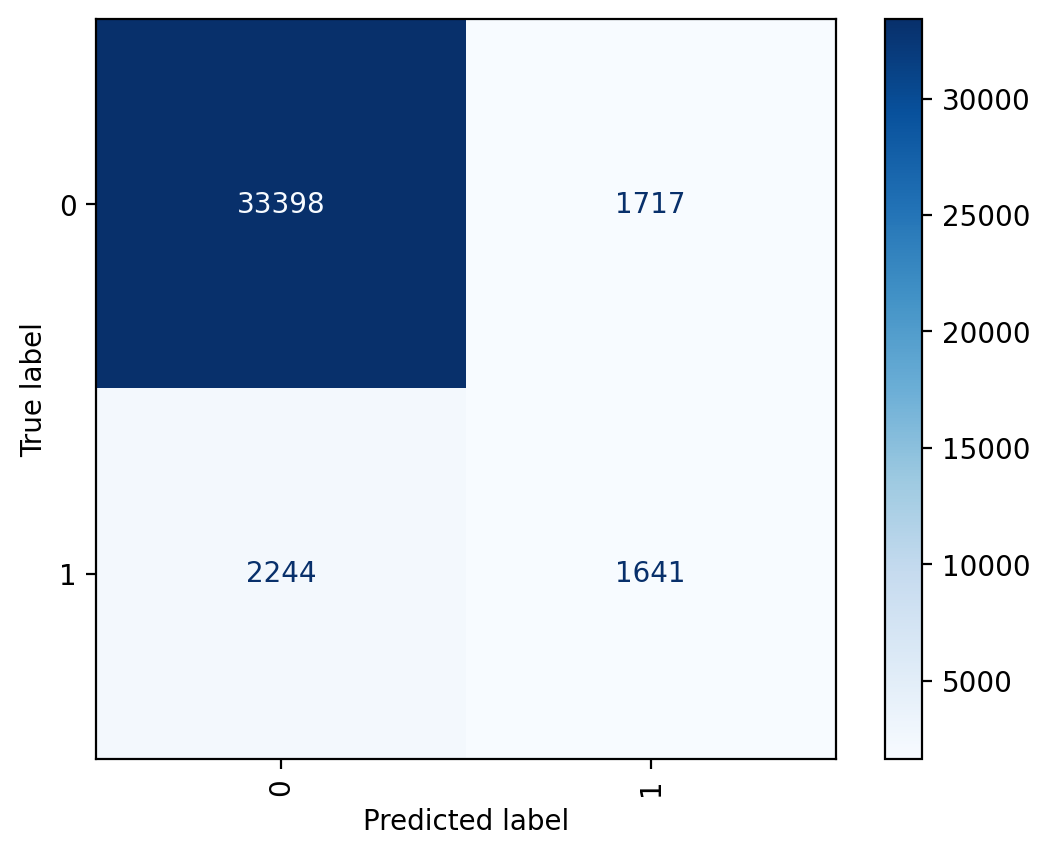

test set accuracy: 89.90%
20000 20000
              precision    recall  f1-score   support

           0       0.94      0.95      0.94     17992
           1       0.50      0.42      0.46      2008

    accuracy                           0.90     20000
   macro avg       0.72      0.69      0.70     20000
weighted avg       0.89      0.90      0.90     20000



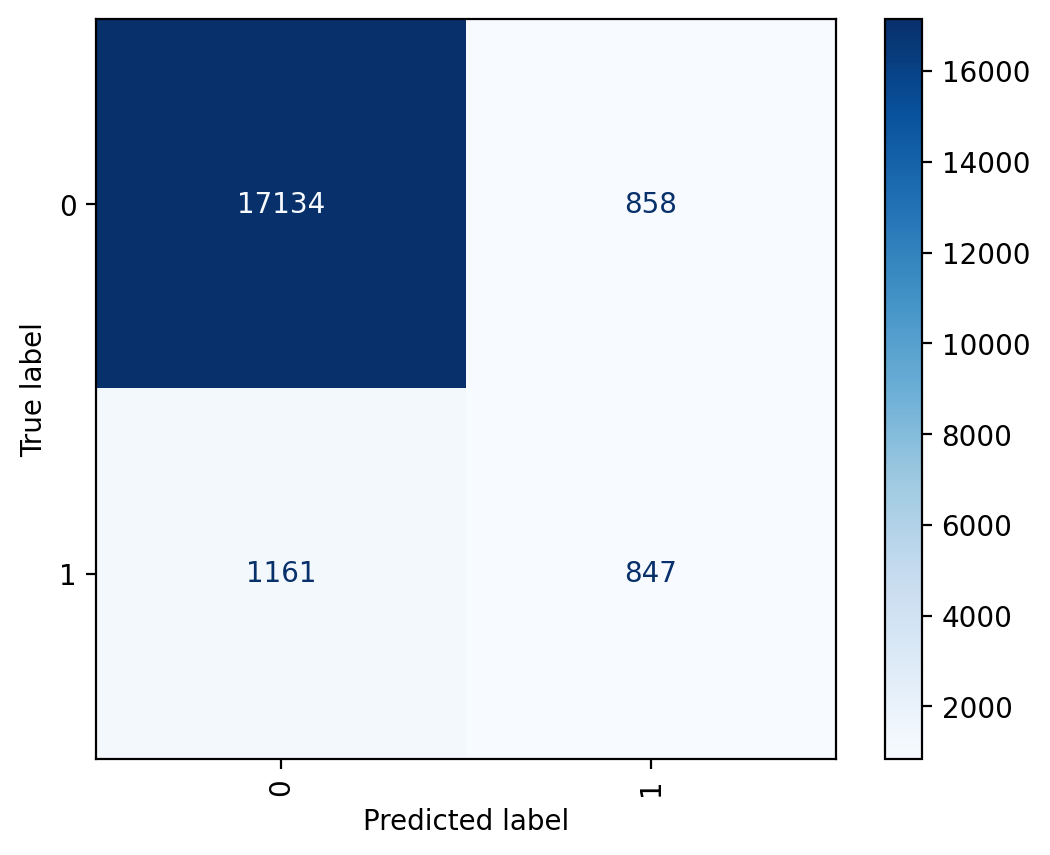

In [19]:
predict(resnet, ["0", "1"], plot_confusion_matrix=True)

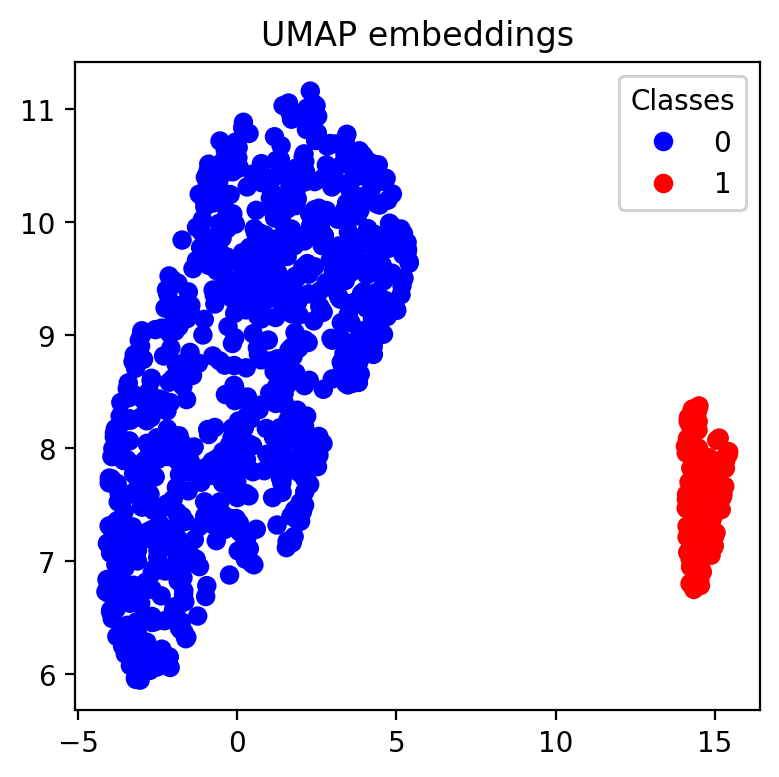

In [20]:
viz_embeddings(resnet, X[train_idx], y[train_idx], device)

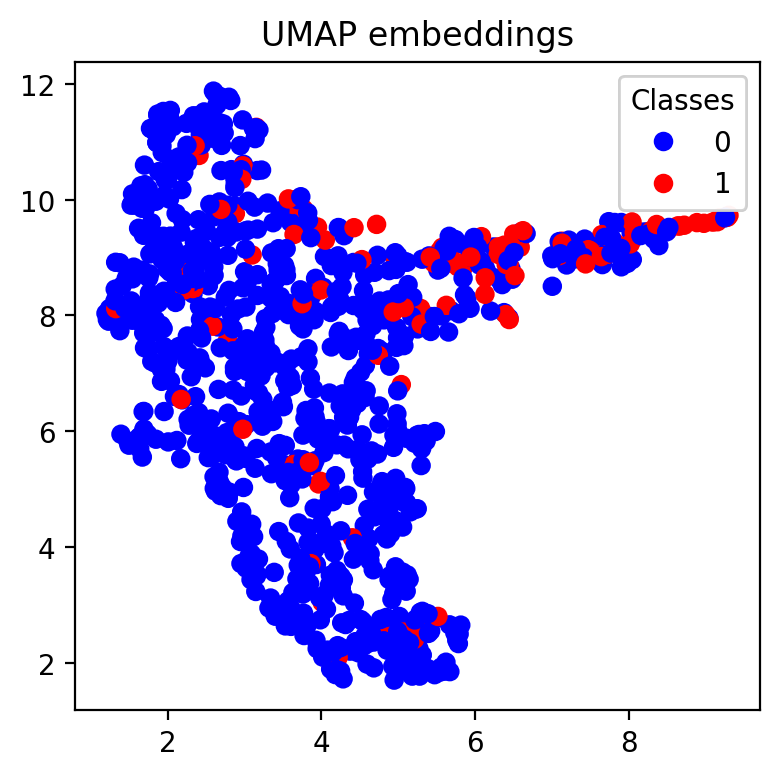

In [21]:
viz_embeddings(resnet, X[test_idx[:1000]], y[test_idx[:1000]], device)

In [22]:
### Train on train + pool
train_plus_pool_idx = torch.cat([train_idx, pool_idx])

resnet = ResNetClassifier(
    models.resnet18, None, n_classes=2, activation=nn.GELU(), dropout=0.1
).to(device)
# convert X to float and y to long
X_float = X[train_plus_pool_idx].float()
y_long = y[train_plus_pool_idx].long()

iter_losses, epoch_losses = train_fn(
    resnet,
    X_float,
    y_long,
    loss_fn=nn.CrossEntropyLoss(),
    lr=3e-4,
    batch_size=1024,
    epochs=30,
)

Loss: 0.248160: 100%|██████████| 40/40 [00:05<00:00,  7.04it/s]


Epoch 1: 0.2476071578979492


Loss: 0.070703: 100%|██████████| 40/40 [00:05<00:00,  7.20it/s]


Epoch 2: 0.15204914817810058


Loss: 0.067759: 100%|██████████| 40/40 [00:05<00:00,  7.21it/s]


Epoch 3: 0.11374607486724854


Loss: 0.054324: 100%|██████████| 40/40 [00:05<00:00,  7.19it/s]


Epoch 4: 0.08226719417572022


Loss: 0.115989: 100%|██████████| 40/40 [00:05<00:00,  7.15it/s]


Epoch 5: 0.06400493927001953


Loss: 0.201836: 100%|██████████| 40/40 [00:05<00:00,  7.14it/s]


Epoch 6: 0.06737851119041442


Loss: 0.033011: 100%|██████████| 40/40 [00:05<00:00,  7.07it/s]


Epoch 7: 0.07346928806304931


Loss: 0.009865: 100%|██████████| 40/40 [00:05<00:00,  7.04it/s]


Epoch 8: 0.03114357726573944


Loss: 0.125881: 100%|██████████| 40/40 [00:05<00:00,  7.04it/s]


Epoch 9: 0.02245280225276947


Loss: 0.045614: 100%|██████████| 40/40 [00:05<00:00,  7.09it/s]


Epoch 10: 0.04457161784172058


Loss: 0.002392: 100%|██████████| 40/40 [00:05<00:00,  7.06it/s]


Epoch 11: 0.044926593589782716


Loss: 0.022740: 100%|██████████| 40/40 [00:05<00:00,  7.07it/s]


Epoch 12: 0.0093979796230793


Loss: 0.084799: 100%|██████████| 40/40 [00:05<00:00,  7.07it/s]


Epoch 13: 0.027779813432693482


Loss: 0.102611: 100%|██████████| 40/40 [00:05<00:00,  7.02it/s]


Epoch 14: 0.03941333243846893


Loss: 0.023010: 100%|██████████| 40/40 [00:05<00:00,  7.07it/s]


Epoch 15: 0.033256324863433835


Loss: 0.016095: 100%|██████████| 40/40 [00:05<00:00,  7.06it/s]


Epoch 16: 0.015572182226181031


Loss: 0.014320: 100%|██████████| 40/40 [00:05<00:00,  7.04it/s]


Epoch 17: 0.011554135304689407


Loss: 0.007664: 100%|██████████| 40/40 [00:05<00:00,  7.05it/s]


Epoch 18: 0.011901084160804749


Loss: 0.007354: 100%|██████████| 40/40 [00:05<00:00,  7.04it/s]


Epoch 19: 0.006904350453615189


Loss: 0.001365: 100%|██████████| 40/40 [00:05<00:00,  7.04it/s]


Epoch 20: 0.012723659539222717


Loss: 0.064760: 100%|██████████| 40/40 [00:05<00:00,  7.06it/s]


Epoch 21: 0.005537655259668827


Loss: 0.022484: 100%|██████████| 40/40 [00:05<00:00,  7.07it/s]


Epoch 22: 0.03971680772304535


Loss: 0.011641: 100%|██████████| 40/40 [00:05<00:00,  6.98it/s]


Epoch 23: 0.013374053859710694


Loss: 0.013502: 100%|██████████| 40/40 [00:05<00:00,  7.01it/s]


Epoch 24: 0.010512905275821686


Loss: 0.001112: 100%|██████████| 40/40 [00:05<00:00,  7.03it/s]


Epoch 25: 0.011869894009828567


Loss: 0.015528: 100%|██████████| 40/40 [00:05<00:00,  7.02it/s]


Epoch 26: 0.002296957431733608


Loss: 0.001595: 100%|██████████| 40/40 [00:05<00:00,  7.01it/s]


Epoch 27: 0.009141598200798035


Loss: 0.000045: 100%|██████████| 40/40 [00:05<00:00,  6.99it/s]


Epoch 28: 0.0018483582539483906


Loss: 0.018692: 100%|██████████| 40/40 [00:05<00:00,  6.95it/s]


Epoch 29: 0.0009976443206891417


Loss: 0.033965: 100%|██████████| 40/40 [00:05<00:00,  7.00it/s]

Epoch 30: 0.0363354043006897


Text(0, 0.5, 'Training loss')

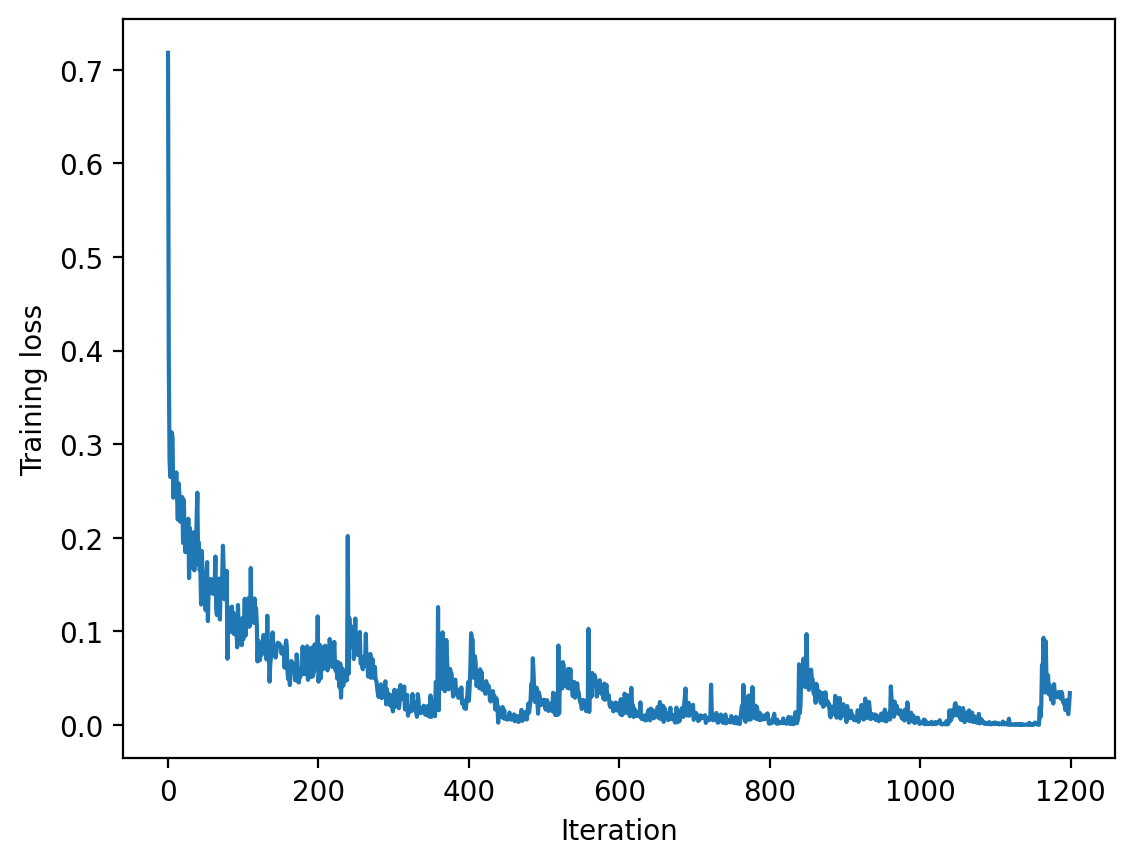

In [23]:
plt.plot(iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Training loss")

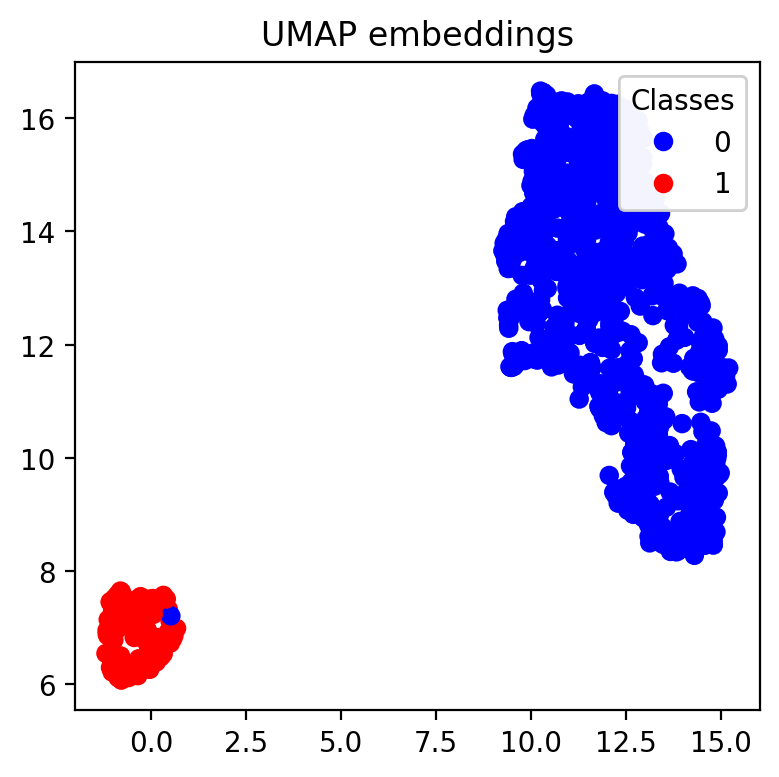

In [24]:
viz_embeddings(resnet, X[train_idx], y[train_idx], device)

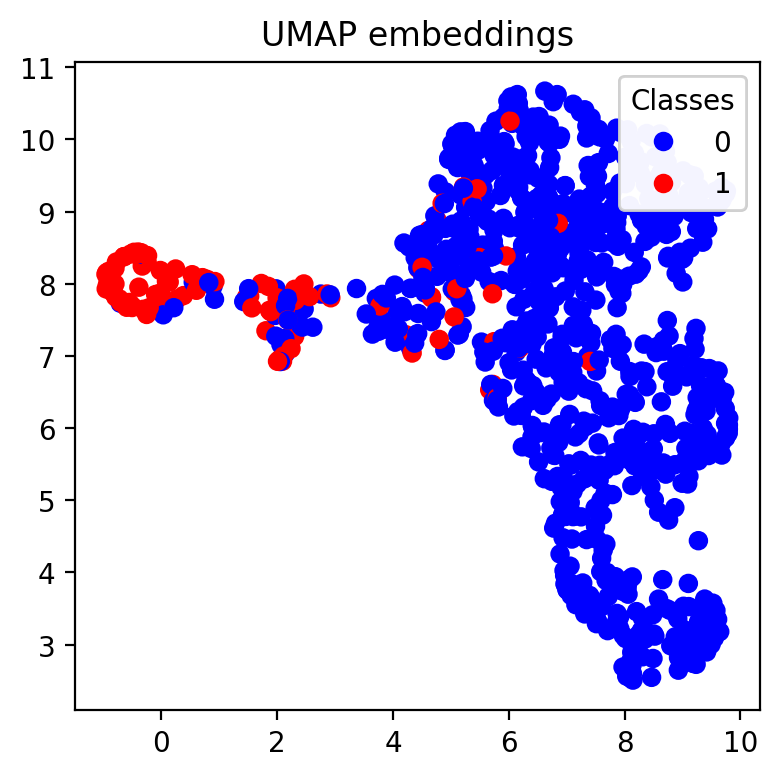

In [25]:
viz_embeddings(resnet, X[test_idx[:1000]], y[test_idx[:1000]], device)

train set accuracy: 100.00%
1000 1000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       893
           1       1.00      1.00      1.00       107

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



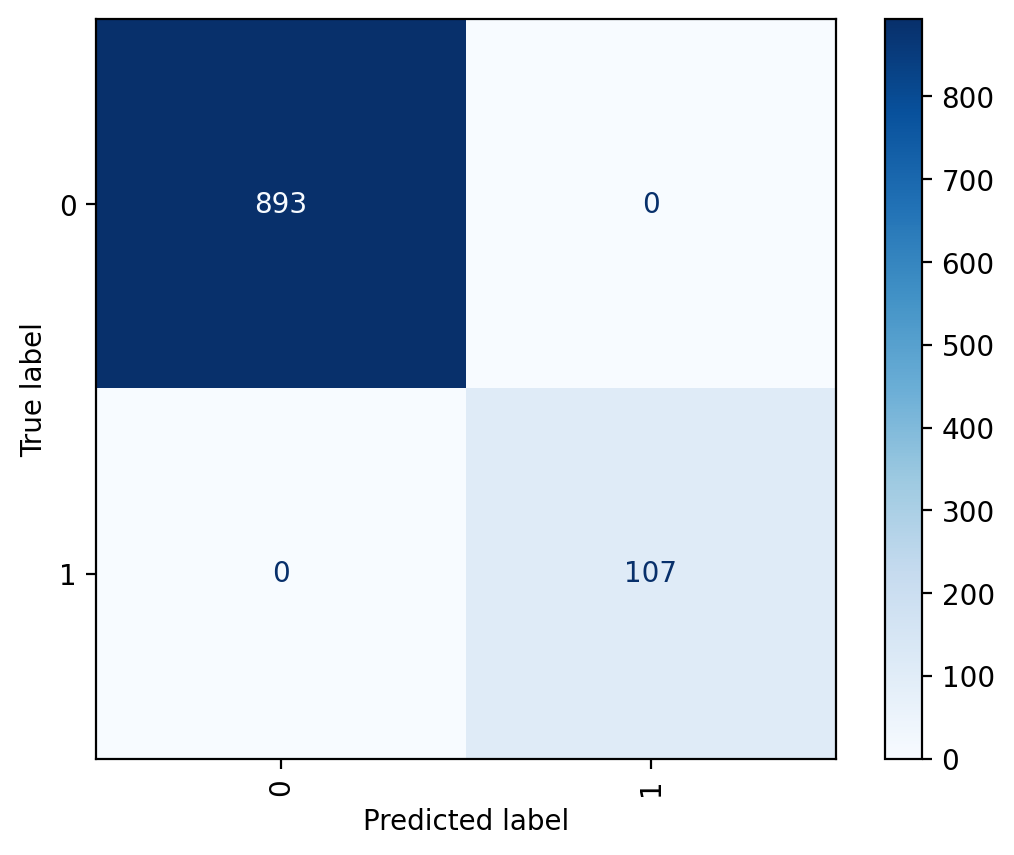

pool set accuracy: 99.73%
39000 39000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     35115
           1       0.99      0.99      0.99      3885

    accuracy                           1.00     39000
   macro avg       0.99      0.99      0.99     39000
weighted avg       1.00      1.00      1.00     39000



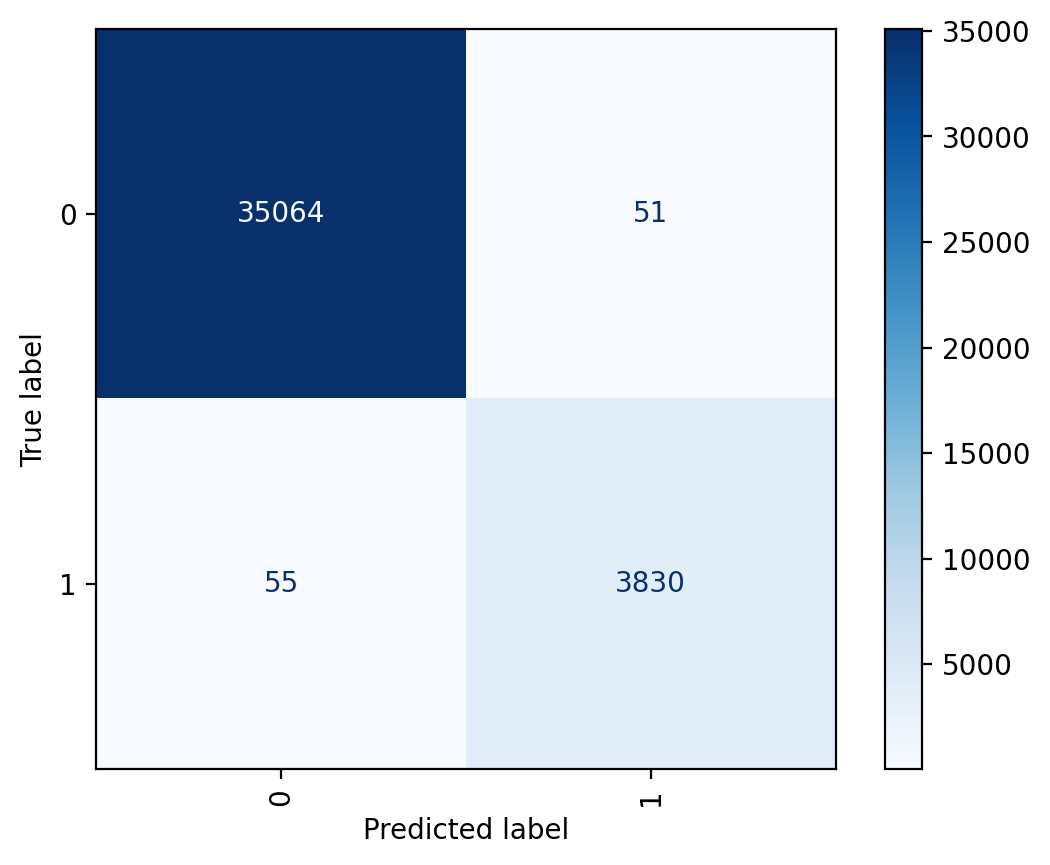

test set accuracy: 93.94%
20000 20000
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     17992
           1       0.71      0.68      0.69      2008

    accuracy                           0.94     20000
   macro avg       0.84      0.82      0.83     20000
weighted avg       0.94      0.94      0.94     20000



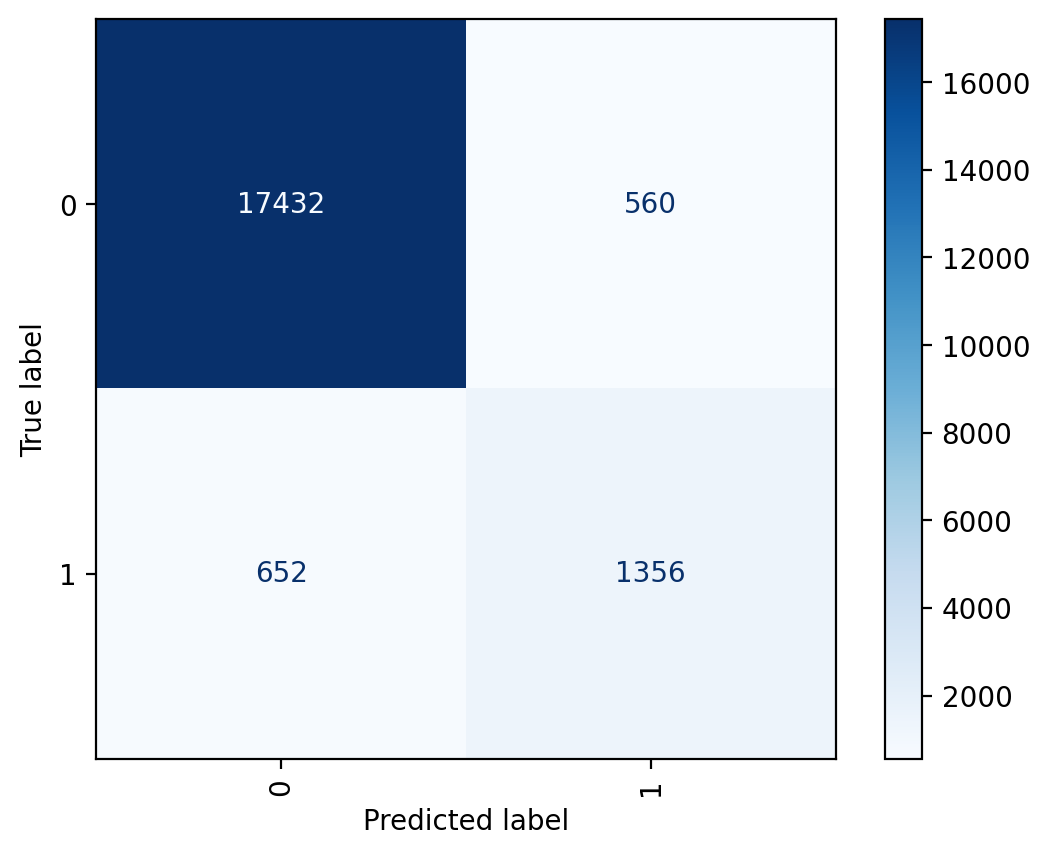

In [26]:
predict(resnet, ["0", "1"], plot_confusion_matrix=True)

## SSL

In [27]:
X_train_plus_pool = torch.cat([X[train_idx], X[pool_idx]])
y_train_plus_pool = torch.cat([y[train_idx], y[pool_idx]])


X_train_plus_pool.shape, y_train_plus_pool.shape

(torch.Size([40000, 3, 32, 32]), torch.Size([40000]))

In [28]:
X_ssl = []
y_ssl = []

angles_map = {0: 0, 90: 1, 180: 2, 270: 3}
for angle_rot in angles_map.keys():
    print(f"Angle: {angle_rot}")
    X_rot = transforms.functional.rotate(X_train_plus_pool, angle_rot)
    X_ssl.append(X_rot)
    y_ssl.append(torch.tensor([angles_map[angle_rot]] * len(X_rot)))

X_ssl = torch.cat(X_ssl)
y_ssl = torch.cat(y_ssl)

Angle: 0
Angle: 90
Angle: 180
Angle: 270


In [29]:
X_ssl.shape, y_ssl.shape

(torch.Size([160000, 3, 32, 32]), torch.Size([160000]))

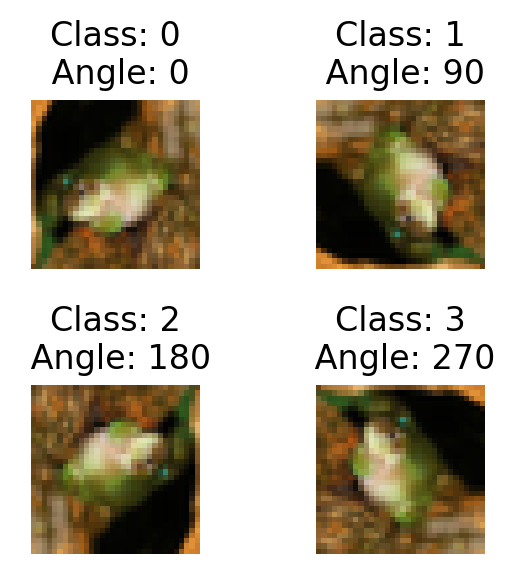

In [30]:
# Plot same image rotated at different angles
def plot_ssl(img_id):
    plt.figure(figsize=(3, 3))
    offset = len(X_train_plus_pool)
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.imshow(torch.einsum("chw->hwc", X_ssl[offset * i + img_id]))
        plt.axis("off")
        plt.title(f"Class: {angles_map[i*90]}\n Angle: {i*90}")
    plt.tight_layout()


plot_ssl(6)

In [31]:
ssl_angle = ResNetClassifier(
    models.resnet18, None, n_classes=4, activation=nn.GELU(), dropout=0.1
).to(device)

In [32]:
iter_losses, epoch_losses = train_fn(
    ssl_angle,
    X_ssl,
    y_ssl,
    lr=3e-4,
    loss_fn=nn.CrossEntropyLoss(),
    batch_size=1024,
    epochs=20,
)

Loss: 0.820561: 100%|██████████| 157/157 [00:23<00:00,  6.80it/s]


Epoch 1: 0.9944818218231202


Loss: 0.855782: 100%|██████████| 157/157 [00:22<00:00,  6.90it/s]


Epoch 2: 0.8224686435699463


Loss: 0.709848: 100%|██████████| 157/157 [00:22<00:00,  6.89it/s]


Epoch 3: 0.7245866371154785


Loss: 0.547411: 100%|██████████| 157/157 [00:22<00:00,  6.89it/s]


Epoch 4: 0.6416291088104248


Loss: 0.667562: 100%|██████████| 157/157 [00:22<00:00,  6.84it/s]


Epoch 5: 0.5667628547668457


Loss: 0.502057: 100%|██████████| 157/157 [00:22<00:00,  6.88it/s]


Epoch 6: 0.48742820320129393


Loss: 0.363637: 100%|██████████| 157/157 [00:22<00:00,  6.85it/s]


Epoch 7: 0.41418192386627195


Loss: 0.471274: 100%|██████████| 157/157 [00:22<00:00,  6.83it/s]


Epoch 8: 0.3417256423950195


Loss: 0.319918: 100%|██████████| 157/157 [00:22<00:00,  6.88it/s]


Epoch 9: 0.2810506260871887


Loss: 0.358376: 100%|██████████| 157/157 [00:22<00:00,  6.90it/s]


Epoch 10: 0.22815890665054323


Loss: 0.221304: 100%|██████████| 157/157 [00:22<00:00,  6.89it/s]


Epoch 11: 0.18680888328552245


Loss: 0.155449: 100%|██████████| 157/157 [00:22<00:00,  6.87it/s]


Epoch 12: 0.15242835292816162


Loss: 0.147608: 100%|██████████| 157/157 [00:22<00:00,  6.88it/s]


Epoch 13: 0.13192918410301208


Loss: 0.131467: 100%|██████████| 157/157 [00:22<00:00,  6.90it/s]


Epoch 14: 0.10843811244964599


Loss: 0.091129: 100%|██████████| 157/157 [00:22<00:00,  6.87it/s]


Epoch 15: 0.09330055494308472


Loss: 0.071593: 100%|██████████| 157/157 [00:22<00:00,  6.86it/s]


Epoch 16: 0.08868290669918061


Loss: 0.091171: 100%|██████████| 157/157 [00:22<00:00,  6.86it/s]


Epoch 17: 0.07796691985130311


Loss: 0.092934: 100%|██████████| 157/157 [00:22<00:00,  6.86it/s]


Epoch 18: 0.06981156768798828


Loss: 0.070100: 100%|██████████| 157/157 [00:22<00:00,  6.87it/s]


Epoch 19: 0.06920415399074555


Loss: 0.039953: 100%|██████████| 157/157 [00:22<00:00,  6.86it/s]

Epoch 20: 0.06293473501205445


Text(0, 0.5, 'Training loss')

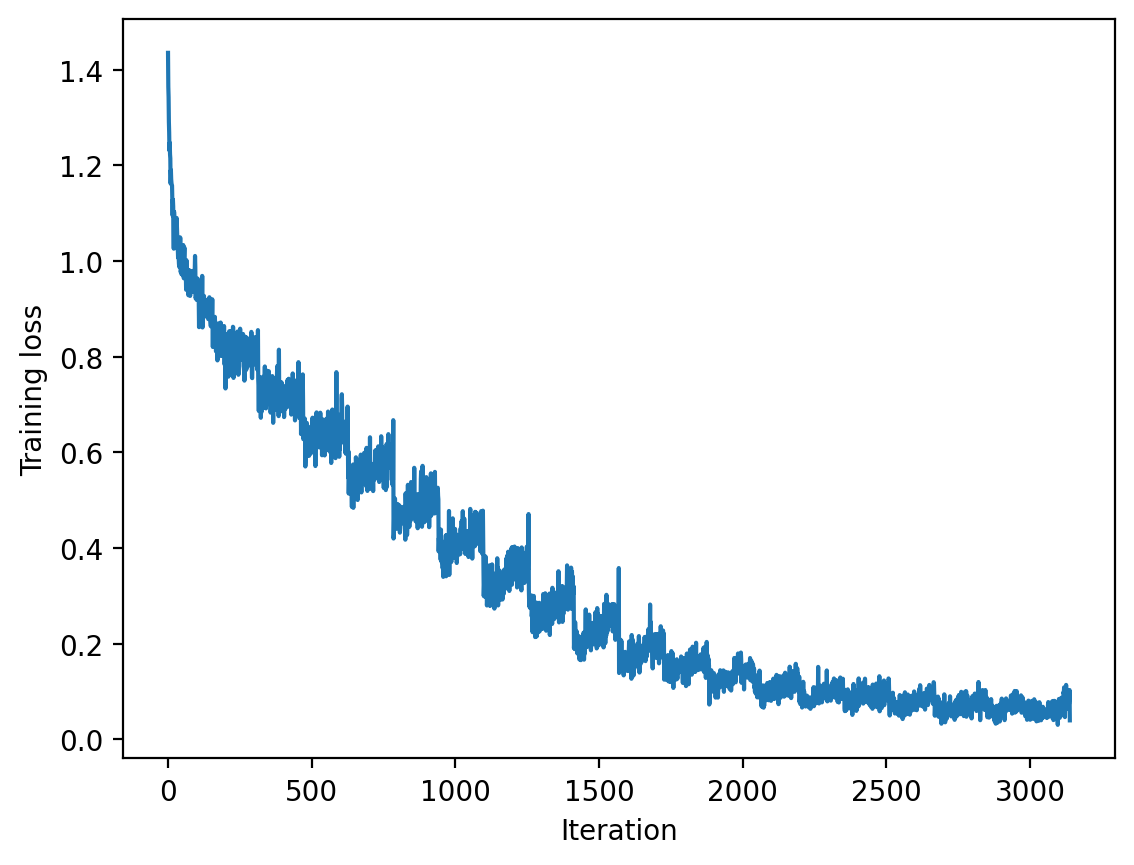

In [33]:
plt.plot(iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Training loss")

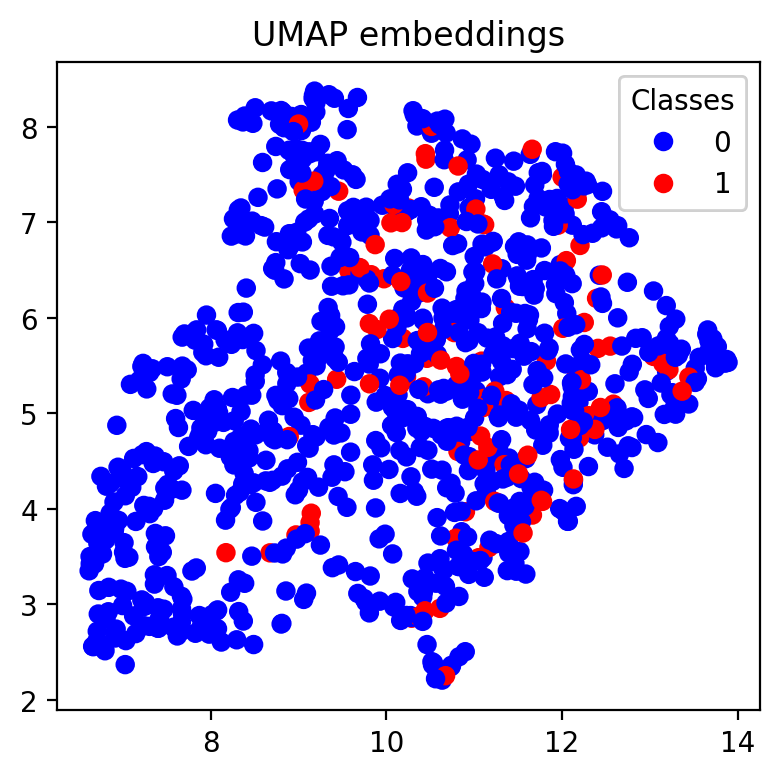

In [34]:
# Visualise the embeddings of the SSL model trained on angles dataset
# (but wrt original 10 classes)
viz_embeddings(ssl_angle, X[train_idx], y[train_idx], device)

In [35]:
# Now, we can use the features from SSLAngle model to train the classifier on the original data

net_pretrained = ResNetClassifier(
    models.resnet18, None, n_classes=2, activation=nn.GELU(), dropout=0.1
).to(device)
net_pretrained.featurizer.load_state_dict(ssl_angle.featurizer.state_dict())
# convert X to float and y to long
X_float = X[train_idx].float()
y_long = y[train_idx].long()

iter_losses, epoch_losses = train_fn(
    net_pretrained,
    X_float,
    y_long,
    nn.CrossEntropyLoss(),
    lr=3e-4,
    epochs=50,
    batch_size=128,
)

Loss: 0.292056: 100%|██████████| 8/8 [00:00<00:00, 36.18it/s]


Epoch 1: 0.34308209228515624


Loss: 0.148152: 100%|██████████| 8/8 [00:00<00:00, 38.57it/s]


Epoch 2: 0.19663076400756835


Loss: 0.057589: 100%|██████████| 8/8 [00:00<00:00, 39.57it/s]


Epoch 3: 0.08811475038528442


Loss: 0.014223: 100%|██████████| 8/8 [00:00<00:00, 39.72it/s]


Epoch 4: 0.02292999267578125


Loss: 0.006757: 100%|██████████| 8/8 [00:00<00:00, 39.96it/s]


Epoch 5: 0.005797457128763199


Loss: 0.000921: 100%|██████████| 8/8 [00:00<00:00, 39.70it/s]


Epoch 6: 0.0033817569464445114


Loss: 0.025461: 100%|██████████| 8/8 [00:00<00:00, 39.69it/s]


Epoch 7: 0.006522346973419189


Loss: 0.002810: 100%|██████████| 8/8 [00:00<00:00, 39.91it/s]


Epoch 8: 0.010578901194036008


Loss: 0.003855: 100%|██████████| 8/8 [00:00<00:00, 39.30it/s]


Epoch 9: 0.01564761679619551


Loss: 0.001717: 100%|██████████| 8/8 [00:00<00:00, 39.38it/s]


Epoch 10: 0.005972212627530098


Loss: 0.001478: 100%|██████████| 8/8 [00:00<00:00, 39.63it/s]


Epoch 11: 0.003637854069471359


Loss: 0.000848: 100%|██████████| 8/8 [00:00<00:00, 38.43it/s]


Epoch 12: 0.0031308008916676043


Loss: 0.001756: 100%|██████████| 8/8 [00:00<00:00, 38.83it/s]


Epoch 13: 0.003216074176132679


Loss: 0.001497: 100%|██████████| 8/8 [00:00<00:00, 39.09it/s]


Epoch 14: 0.001611620180308819


Loss: 0.004500: 100%|██████████| 8/8 [00:00<00:00, 39.81it/s]


Epoch 15: 0.0013105666283518076


Loss: 0.001707: 100%|██████████| 8/8 [00:00<00:00, 39.60it/s]


Epoch 16: 0.0013849395178258418


Loss: 0.000195: 100%|██████████| 8/8 [00:00<00:00, 39.71it/s]


Epoch 17: 0.0005915545225143433


Loss: 0.000071: 100%|██████████| 8/8 [00:00<00:00, 39.39it/s]


Epoch 18: 0.0010769266029819846


Loss: 0.022681: 100%|██████████| 8/8 [00:00<00:00, 39.59it/s]


Epoch 19: 0.010900609349831938


Loss: 0.015177: 100%|██████████| 8/8 [00:00<00:00, 39.82it/s]


Epoch 20: 0.01921024803817272


Loss: 0.048614: 100%|██████████| 8/8 [00:00<00:00, 40.36it/s]


Epoch 21: 0.05406348299980163


Loss: 0.076314: 100%|██████████| 8/8 [00:00<00:00, 40.09it/s]


Epoch 22: 0.05354973465204239


Loss: 0.040854: 100%|██████████| 8/8 [00:00<00:00, 39.87it/s]


Epoch 23: 0.04918732088804245


Loss: 0.016487: 100%|██████████| 8/8 [00:00<00:00, 39.38it/s]


Epoch 24: 0.014498618125915528


Loss: 0.005929: 100%|██████████| 8/8 [00:00<00:00, 39.95it/s]


Epoch 25: 0.008641387060284614


Loss: 0.001272: 100%|██████████| 8/8 [00:00<00:00, 39.96it/s]


Epoch 26: 0.0027087806314229964


Loss: 0.000769: 100%|██████████| 8/8 [00:00<00:00, 39.64it/s]


Epoch 27: 0.001272836621850729


Loss: 0.000404: 100%|██████████| 8/8 [00:00<00:00, 39.14it/s]


Epoch 28: 0.0005453017093241215


Loss: 0.000444: 100%|██████████| 8/8 [00:00<00:00, 39.55it/s]


Epoch 29: 0.0002996561508625746


Loss: 0.000213: 100%|██████████| 8/8 [00:00<00:00, 39.77it/s]


Epoch 30: 0.0003382399510592222


Loss: 0.000525: 100%|██████████| 8/8 [00:00<00:00, 38.76it/s]


Epoch 31: 0.00021553380228579044


Loss: 0.000147: 100%|██████████| 8/8 [00:00<00:00, 37.66it/s]


Epoch 32: 0.00016212609596550465


Loss: 0.000143: 100%|██████████| 8/8 [00:00<00:00, 37.18it/s]


Epoch 33: 0.00013700840435922147


Loss: 0.000096: 100%|██████████| 8/8 [00:00<00:00, 37.58it/s]


Epoch 34: 0.00018689254019409418


Loss: 0.000090: 100%|██████████| 8/8 [00:00<00:00, 37.11it/s]


Epoch 35: 0.00013078500656411052


Loss: 0.000061: 100%|██████████| 8/8 [00:00<00:00, 36.71it/s]


Epoch 36: 7.990786619484425e-05


Loss: 0.000045: 100%|██████████| 8/8 [00:00<00:00, 36.77it/s]


Epoch 37: 7.160229701548814e-05


Loss: 0.000128: 100%|██████████| 8/8 [00:00<00:00, 36.80it/s]


Epoch 38: 0.00010276299808174372


Loss: 0.000030: 100%|██████████| 8/8 [00:00<00:00, 35.76it/s]


Epoch 39: 8.581114793196321e-05


Loss: 0.000073: 100%|██████████| 8/8 [00:00<00:00, 36.04it/s]


Epoch 40: 6.344374176114797e-05


Loss: 0.000049: 100%|██████████| 8/8 [00:00<00:00, 36.13it/s]


Epoch 41: 9.952346840873361e-05


Loss: 0.000054: 100%|██████████| 8/8 [00:00<00:00, 36.68it/s]


Epoch 42: 5.712616071105003e-05


Loss: 0.000066: 100%|██████████| 8/8 [00:00<00:00, 37.43it/s]


Epoch 43: 5.4148409981280564e-05


Loss: 0.000152: 100%|██████████| 8/8 [00:00<00:00, 35.11it/s]


Epoch 44: 7.354847923852504e-05


Loss: 0.000106: 100%|██████████| 8/8 [00:00<00:00, 36.08it/s]


Epoch 45: 6.19093922432512e-05


Loss: 0.000035: 100%|██████████| 8/8 [00:00<00:00, 35.58it/s]


Epoch 46: 5.424201651476324e-05


Loss: 0.000020: 100%|██████████| 8/8 [00:00<00:00, 37.76it/s]


Epoch 47: 4.149835137650371e-05


Loss: 0.000041: 100%|██████████| 8/8 [00:00<00:00, 38.42it/s]


Epoch 48: 3.615918033756316e-05


Loss: 0.000041: 100%|██████████| 8/8 [00:00<00:00, 37.87it/s]


Epoch 49: 4.3249090667814015e-05


Loss: 0.000032: 100%|██████████| 8/8 [00:00<00:00, 37.26it/s]

Epoch 50: 5.9796507004648444e-05


Text(0, 0.5, 'Training loss')

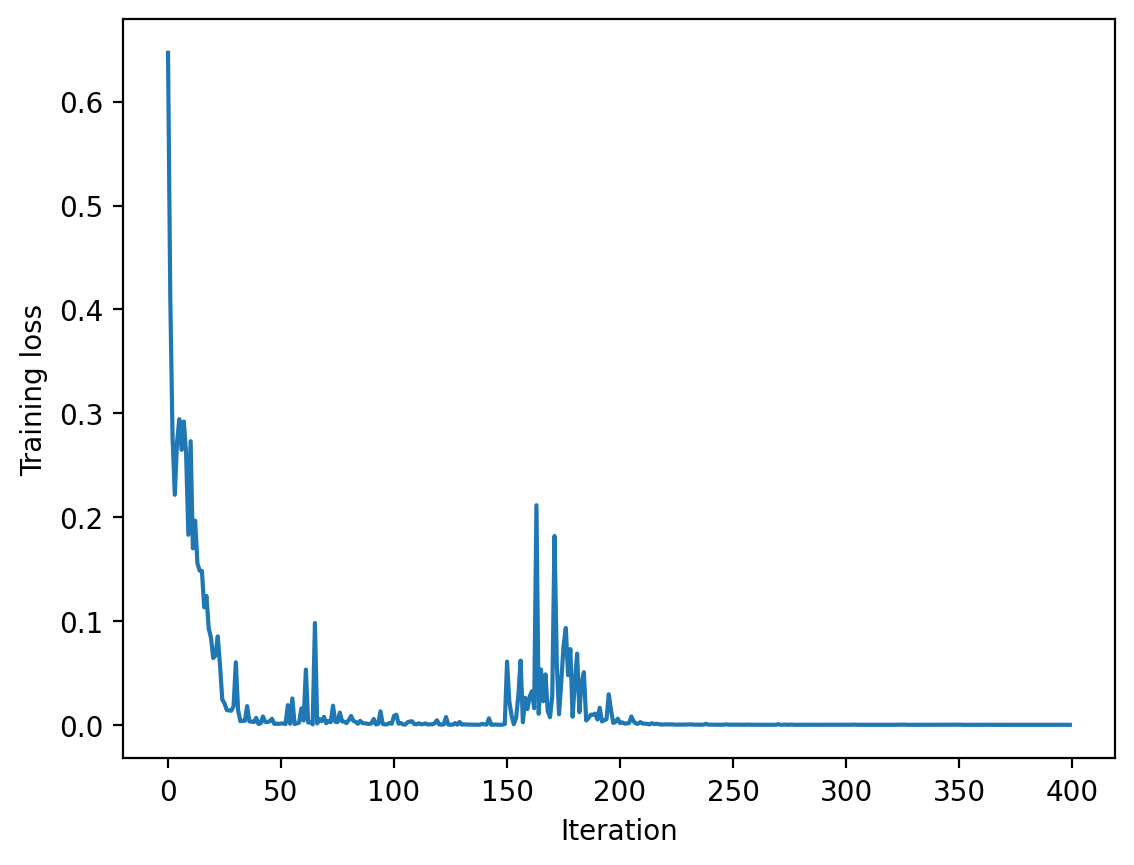

In [36]:
plt.plot(iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Training loss")

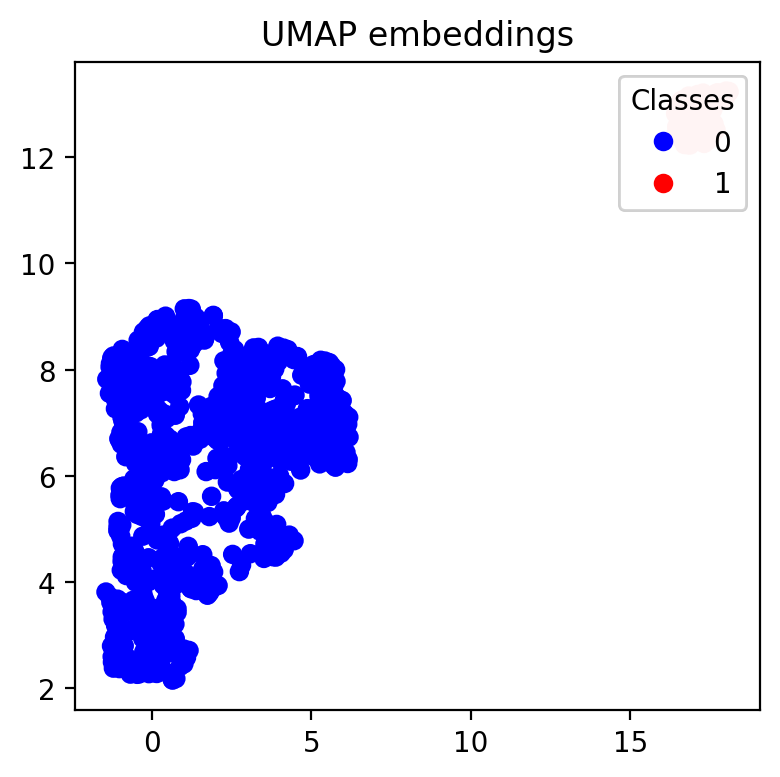

In [37]:
viz_embeddings(net_pretrained, X[train_idx], y[train_idx], device)

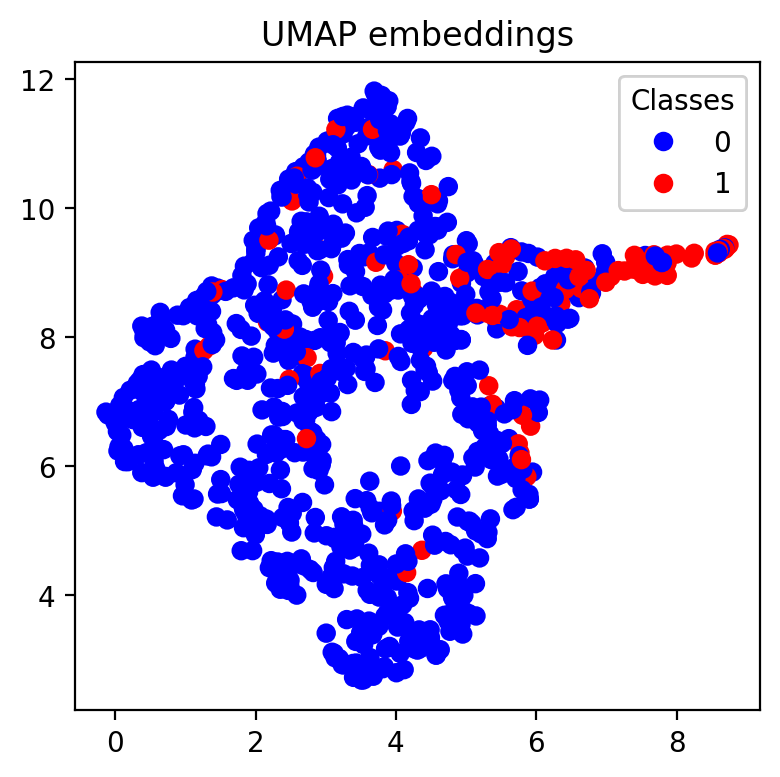

In [38]:
viz_embeddings(net_pretrained, X[test_idx[:1000]], y[test_idx[:1000]], device)

train set accuracy: 100.00%
1000 1000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       893
           1       1.00      1.00      1.00       107

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



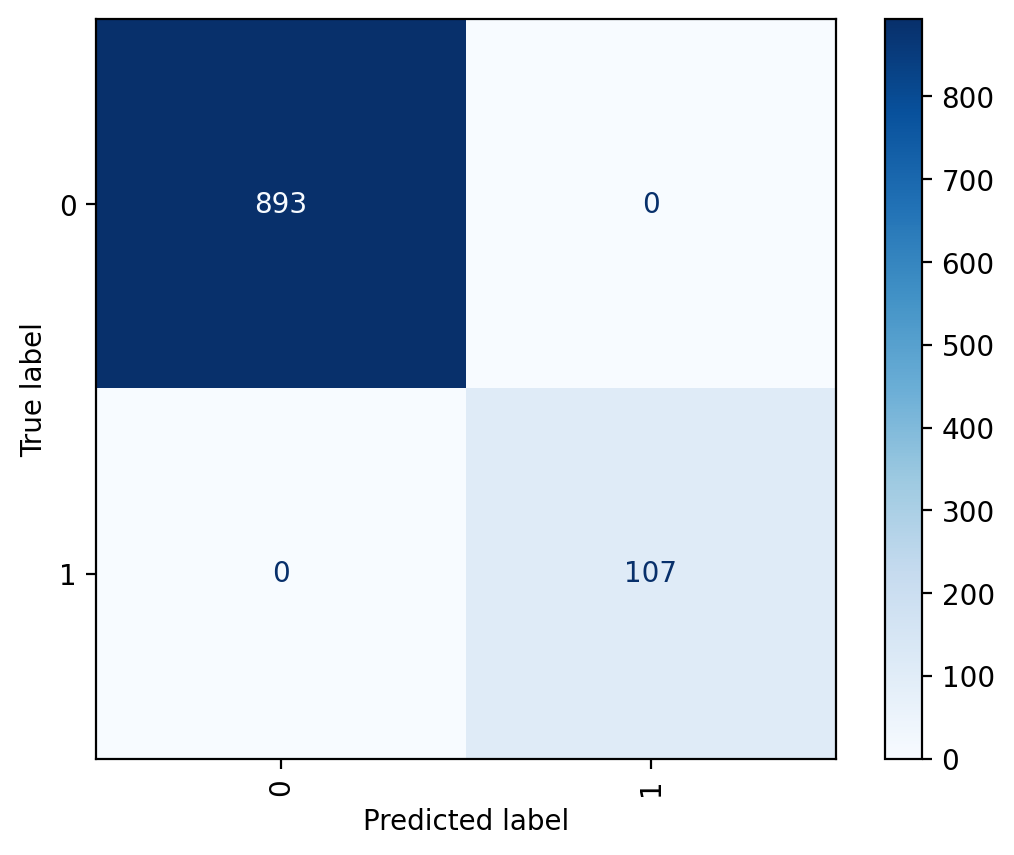

pool set accuracy: 91.09%
39000 39000
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     35115
           1       0.55      0.54      0.55      3885

    accuracy                           0.91     39000
   macro avg       0.75      0.74      0.75     39000
weighted avg       0.91      0.91      0.91     39000



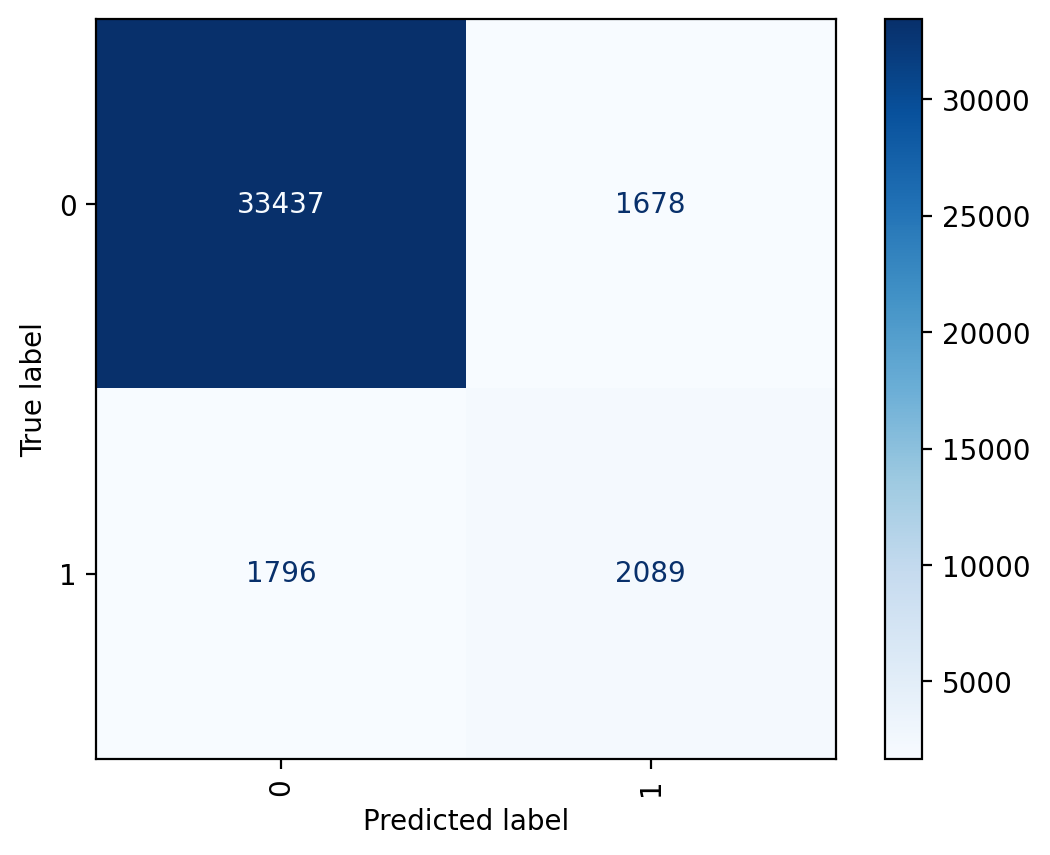

test set accuracy: 90.76%
20000 20000
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     17992
           1       0.54      0.52      0.53      2008

    accuracy                           0.91     20000
   macro avg       0.74      0.74      0.74     20000
weighted avg       0.91      0.91      0.91     20000



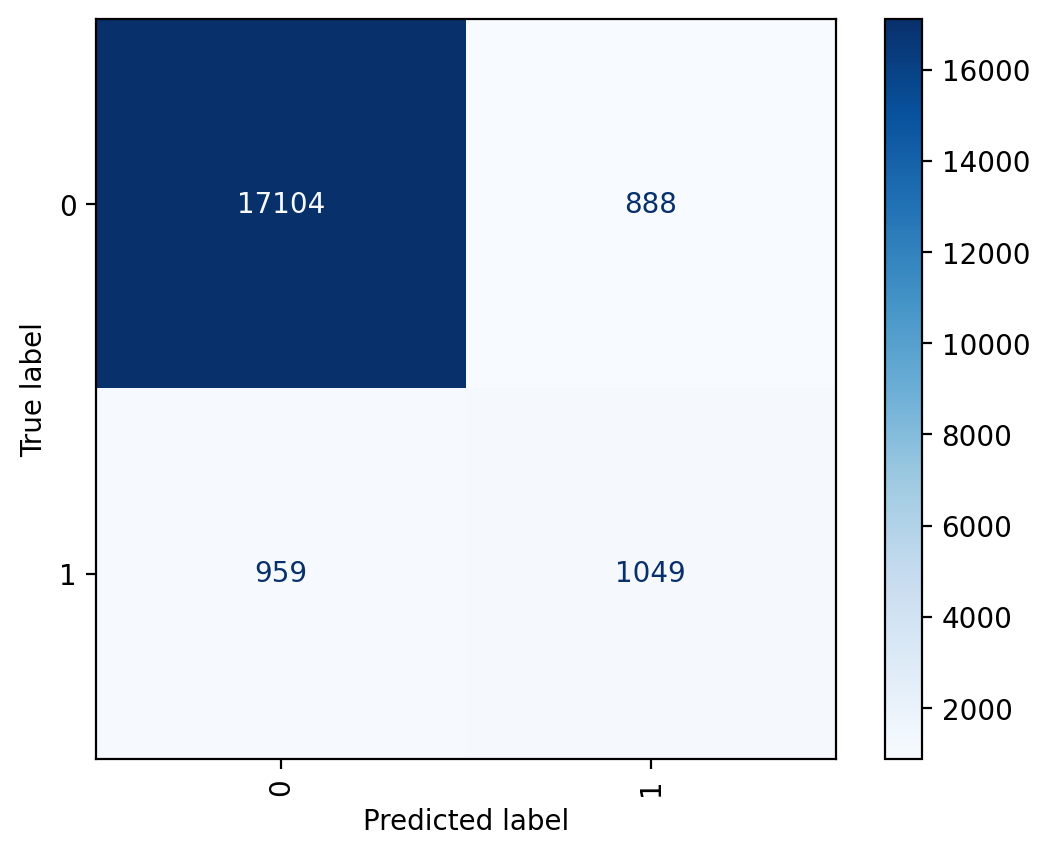

In [39]:
predict(net_pretrained, ["0", "1"], plot_confusion_matrix=True)